# Import everything here

In [1]:
from data_module import *
from Euler import *
from RungeKutta import *

%reload_ext autoreload
%autoreload 2

# Define notebook parameters

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

delta_t = 0.5
t_eval = np.arange(0, 5, delta_t)
num_samples_in_trajectory = math.floor(t_eval[-1] / delta_t)

save_fig = False
save_prefix = "./figures/v0_"

# Setup Tensorboard

In [3]:
%load_ext tensorboard
%tensorboard --logdir euler --port 6006

Launching TensorBoard...

# Create dataset

In [4]:
dataset, alphas = create_dataset(t_eval, 1000)

# Reshape dataset

In [5]:
dataset = reshape_dataset(dataset, alphas)

# Split dataset

In [6]:
training_set, validation_set, test_set = split_dataset(dataset, 0.6, 0.2, 0.2)

# Create NN model and define hyperparameters

In [7]:
hparams = {
    "hidden_layer_1": 512,
    "hidden_layer_2": 512,
    "hidden_layer_3": 512,
    "delta_t": delta_t,
    "batch_size": 128,
    "learning_rate": 1e-3,
    "num_workers": 8,
}

In [8]:
model_euler = Euler(hparams)

In [9]:
model_rk = RungeKutta(hparams)

# Original Data

In [10]:
t_eval = np.delete(t_eval, -1, 0)

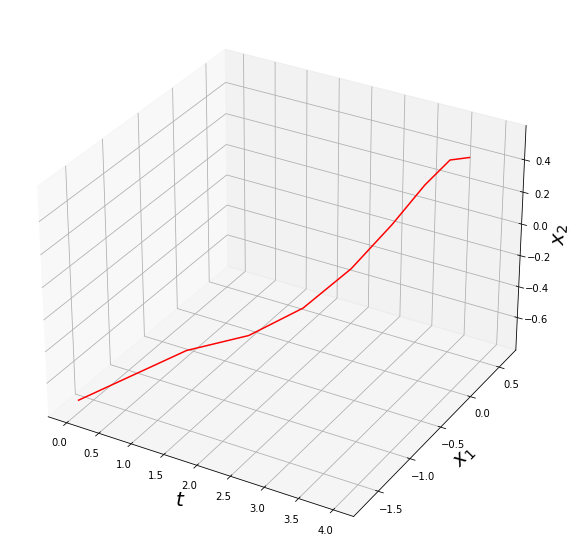

In [11]:
plot_trajectory(validation_set[:num_samples_in_trajectory, :2], t_eval, save_fig, save_prefix + "_original_data.png")

# Validation set

Score of the Euler Model before training: 3.826355050091319
Score of the RK Model before training: 3.785426346589177


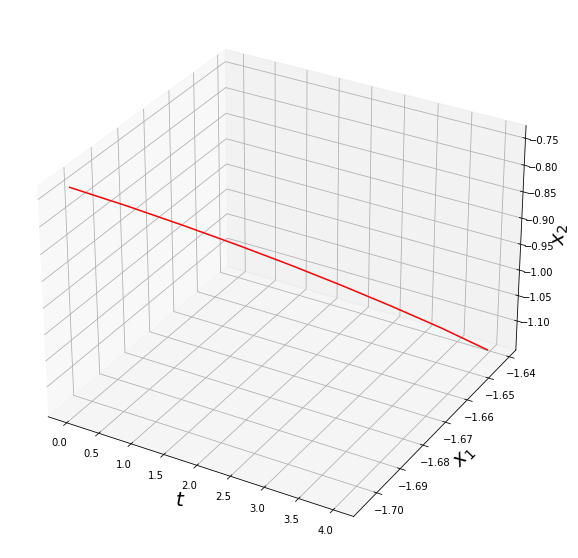

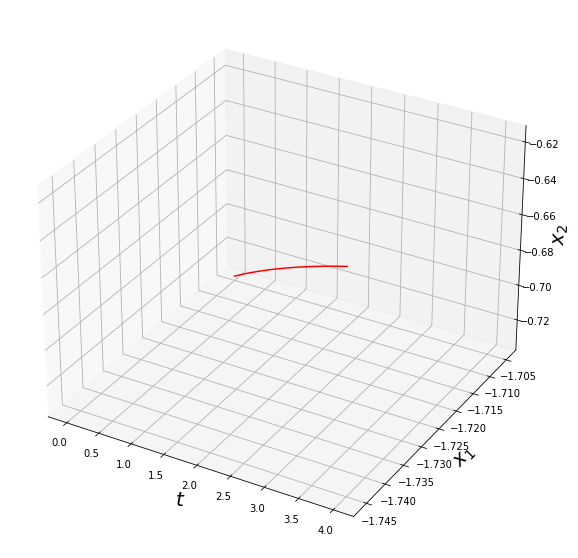

In [12]:
print("Score of the Euler Model before training:", evaluate_model(model_euler, validation_set, hparams, device))
print("Score of the RK Model before training:", evaluate_model(model_rk, validation_set, hparams, device))

recreation = recreate_trajectory(model_euler, validation_set[0, :3], t_eval[0], t_eval[-1], delta_t, device)
plot_trajectory(recreation, t_eval, save_fig, save_prefix + "_b_train.png")
recreation = recreate_trajectory(model_rk, validation_set[0, :3], t_eval[0], t_eval[-1], delta_t, device)
plot_trajectory(recreation, t_eval, save_fig, save_prefix + "rk_b_train.png")

In [13]:
train_dataloader = DataLoader(training_set,
                              shuffle=False,
                              batch_size=hparams["batch_size"],
                              num_workers=8)

In [14]:
trainer = pl.Trainer(
    max_epochs=100,
    log_every_n_steps=5,
    gpus=1 if torch.cuda.is_available() else None
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model_euler, train_dataloader)


  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 528 K 
-------------------------------------
528 K     Trainable params
0         Non-trainable params
528 K     Total params
2.114     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [16]:
trainer = pl.Trainer(
    max_epochs=100,
    log_every_n_steps=5,
    gpus=1 if torch.cuda.is_available() else None
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model_rk, train_dataloader)


  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 528 K 
-------------------------------------
528 K     Trainable params
0         Non-trainable params
528 K     Total params
2.114     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Score of the Euler Model after training: 10775.052664895147
Score of the RK Model after training: 39933.655063043


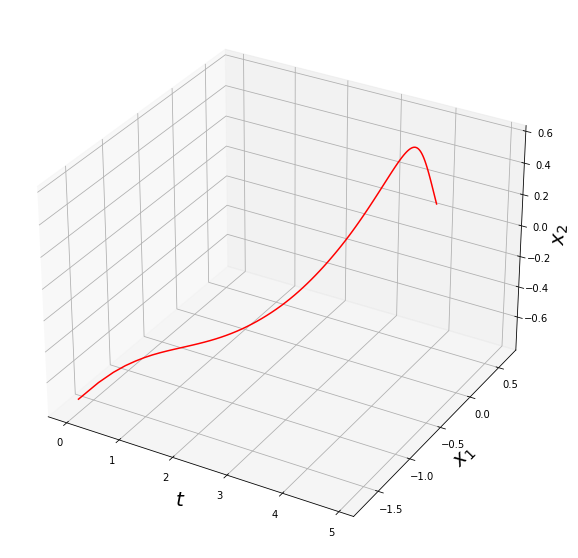

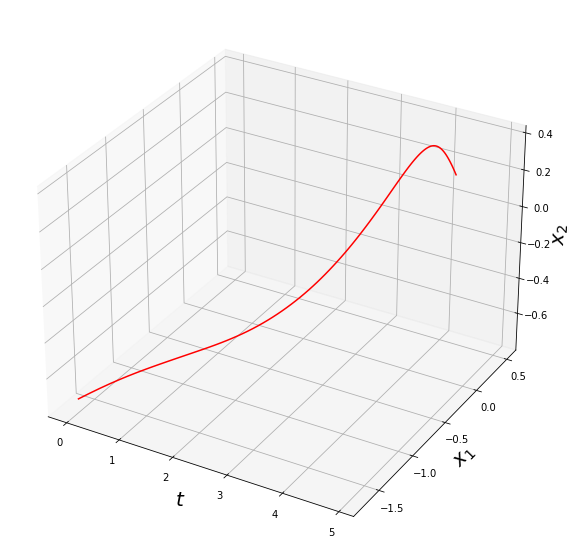

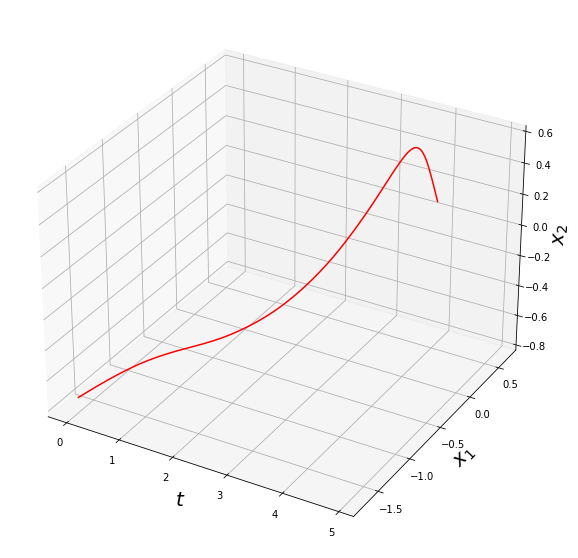

In [18]:
model_euler.hparams["delta_t"] = delta_t
model_rk.hparams["delta_t"] = delta_t

print("Score of the Euler Model after training:", evaluate_model(model_euler, validation_set, hparams, device))
print("Score of the RK Model after training:", evaluate_model(model_rk, validation_set, hparams, device))

model_euler.hparams["delta_t"] = 0.05
model_rk.hparams["delta_t"] = 0.05

t_eval_tmp = np.arange(0, 5, 0.05).round(2)
t_eval_tmp = np.delete(t_eval_tmp, -1, 0)

sol = solve_ivp(lambda t, y: andronov_hopf(y[0], y[1], validation_set[0, 2]), (0, 10), validation_set[0, :2], t_eval=t_eval_tmp)
plot_trajectory(np.moveaxis(sol.y, 0, 1), t_eval_tmp, save_fig, save_prefix + "dense_original_data.png")

recreation = recreate_trajectory(model_euler, validation_set[0, :3], t_eval_tmp[0], t_eval_tmp[-1], model_euler.hparams["delta_t"], device)
plot_trajectory(recreation, t_eval_tmp, save_fig, save_prefix + "_a_train.png")

recreation = recreate_trajectory(model_rk, validation_set[0, :3], t_eval_tmp[0], t_eval_tmp[-1], model_rk.hparams["delta_t"], device)
plot_trajectory(recreation, t_eval_tmp, save_fig, save_prefix + "rk_a_train.png")

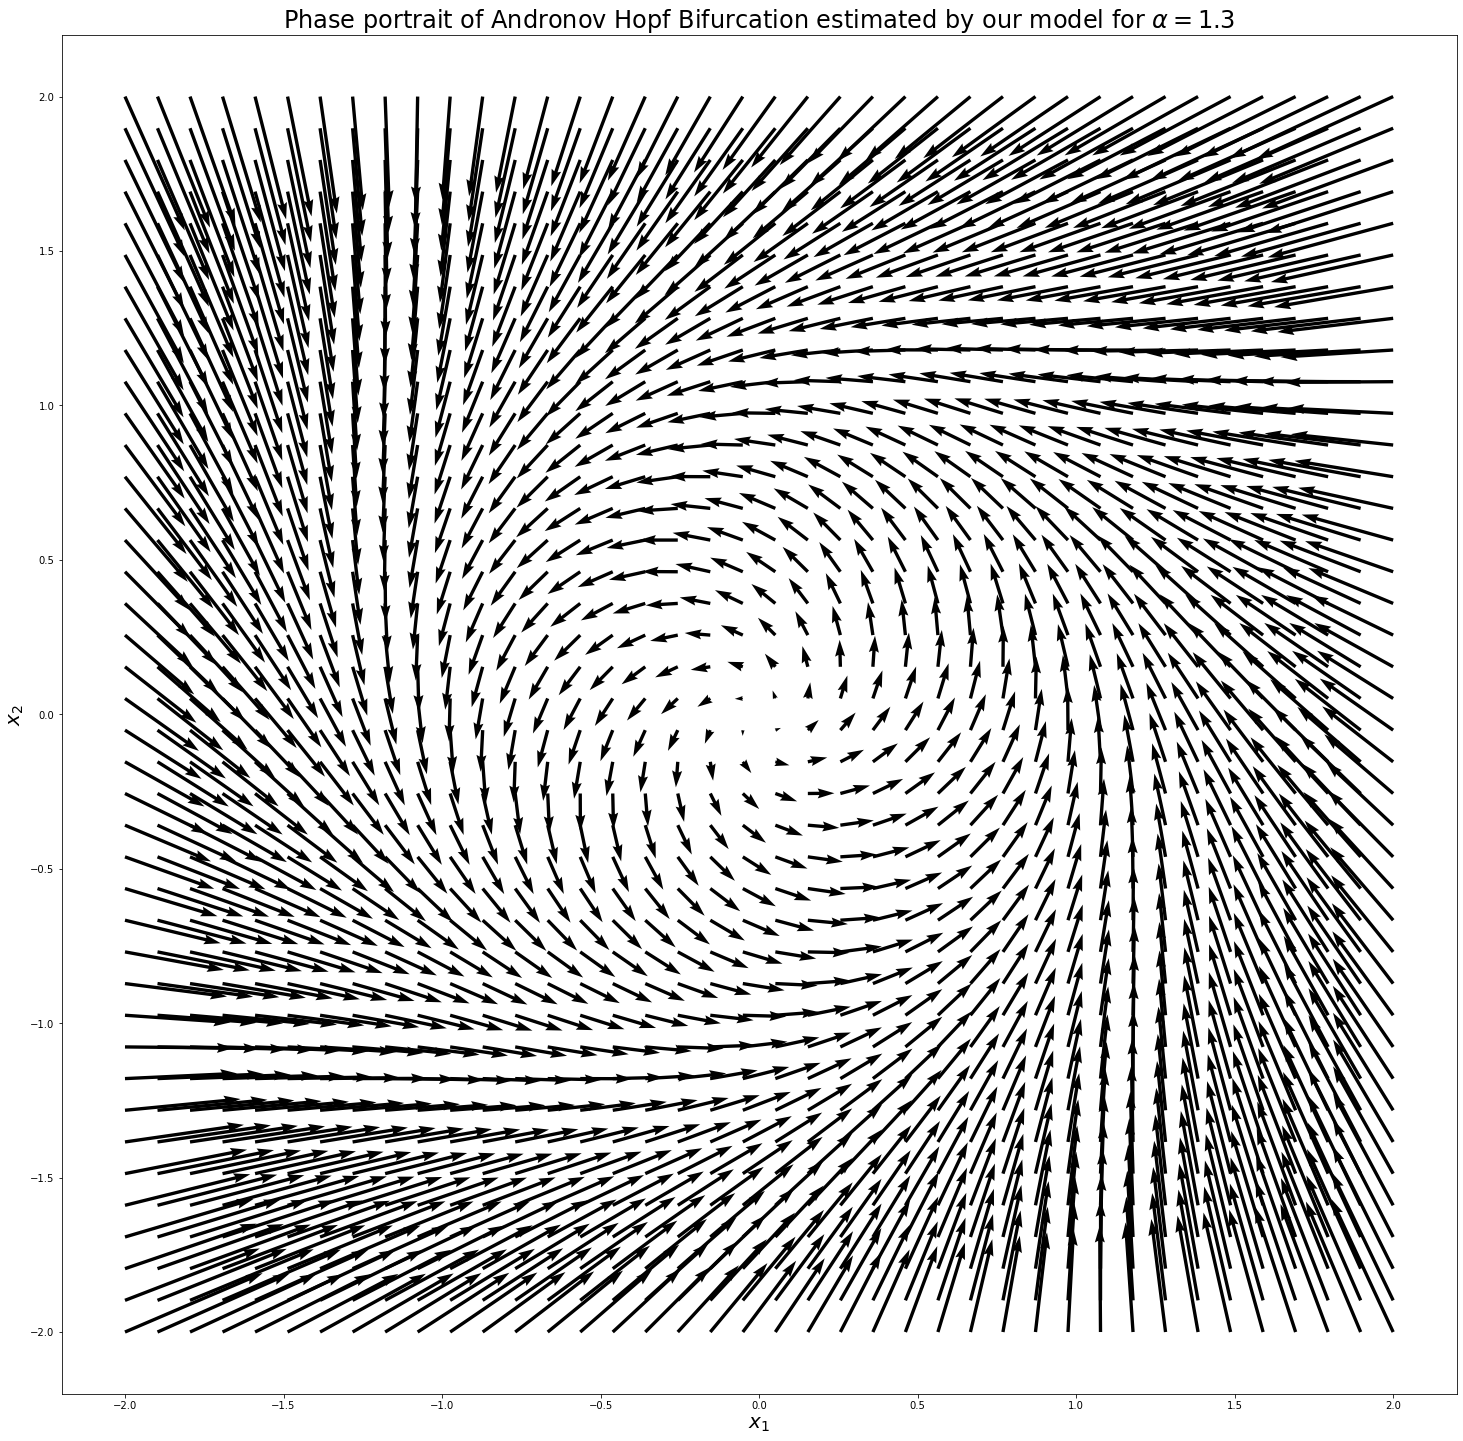

In [19]:
compute_and_plot_phase_portrait(model_euler, 1.3, save_fig, save_prefix + "_phase_portrait.png")

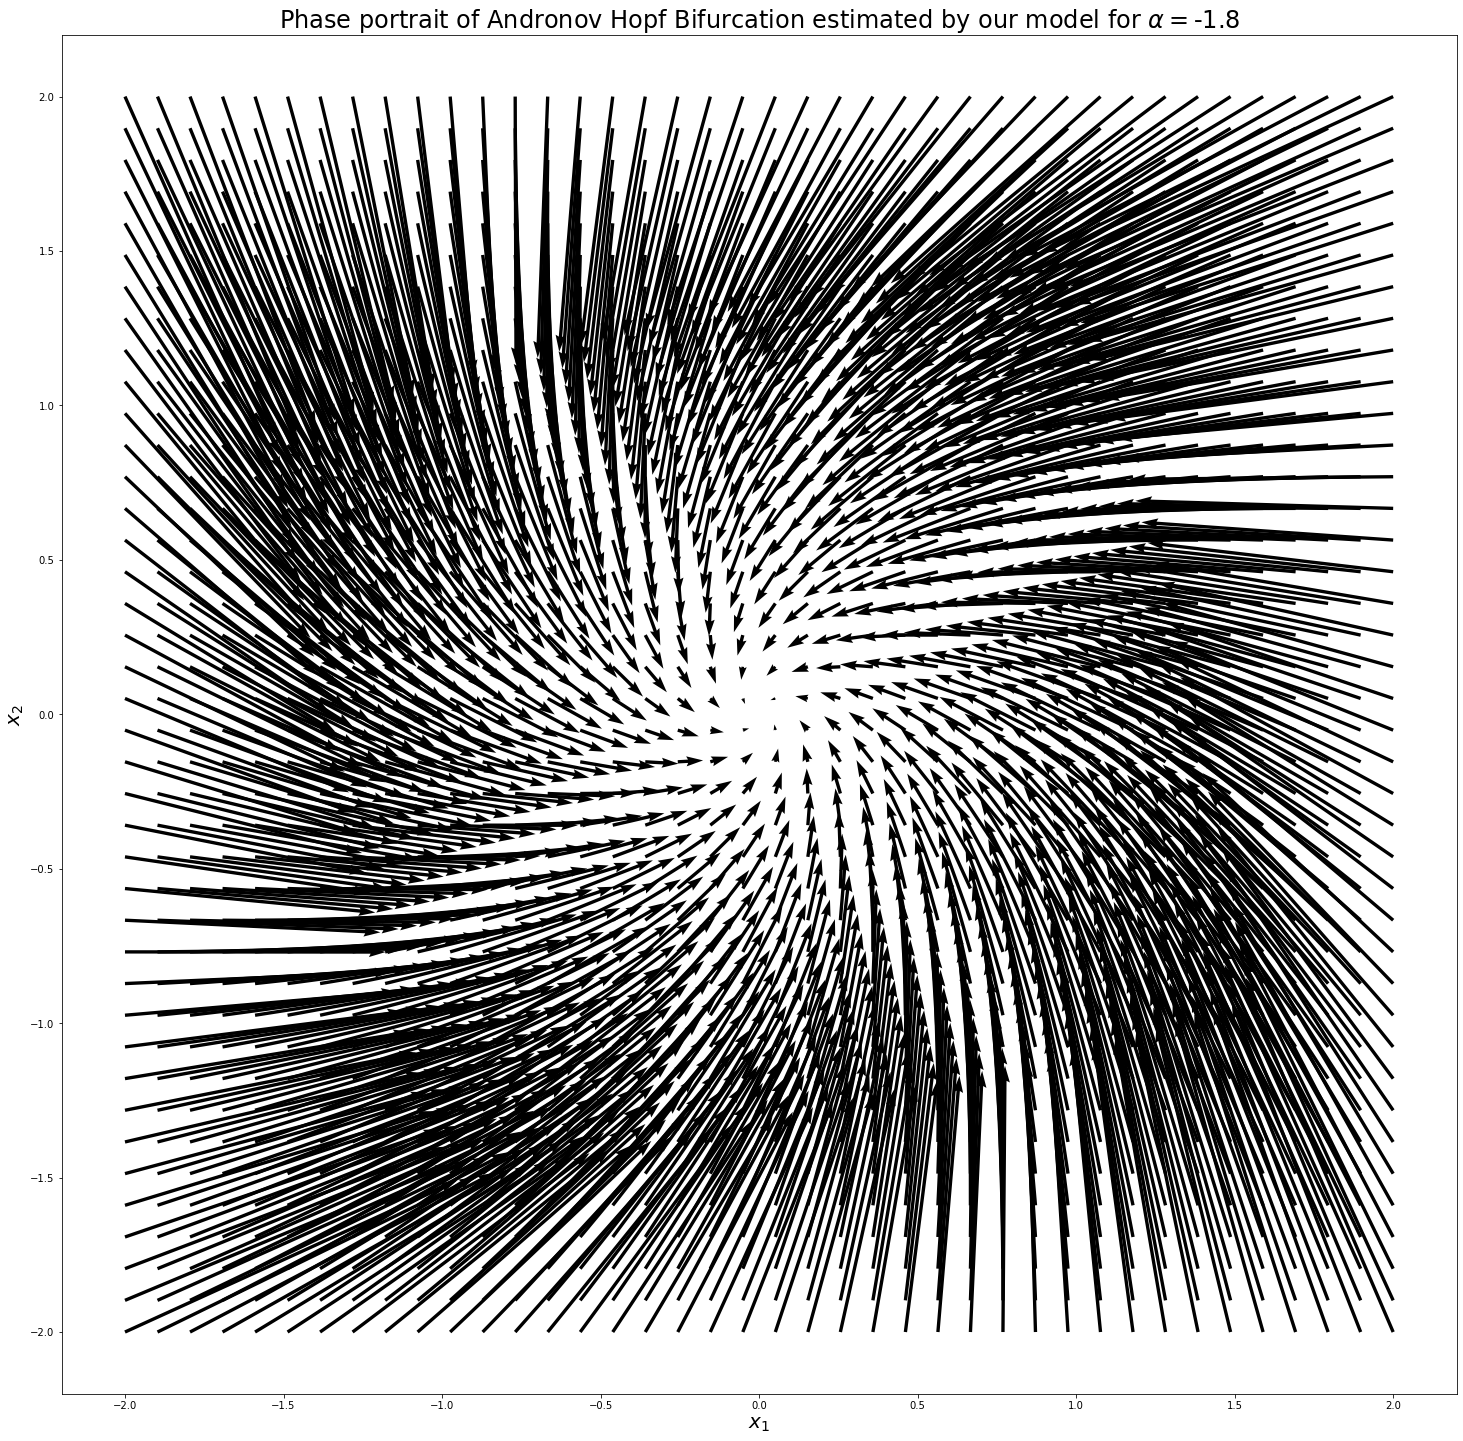

In [26]:
compute_and_plot_phase_portrait(model_rk, -1.8, save_fig, save_prefix + "rk_phase_portrait.png")

In [21]:
alphas, steady_states = compute_and_plot_bifurcation_diagram(model_rk, 0.05)

In [23]:
print(steady_states[:21])

[array({(0.0, 0.0)}, dtype=object) array({(0.0, 0.0)}, dtype=object)
 array({(0.0, 0.0)}, dtype=object) array({(0.0, 0.0)}, dtype=object)
 array({(0.0, 0.0)}, dtype=object) array({(0.0, 0.0)}, dtype=object)
 array({(0.0, 0.0)}, dtype=object) array({(0.0, 0.0)}, dtype=object)
 array({(0.0, 0.0)}, dtype=object) array({(-0.0, 0.0)}, dtype=object)
 array({(-0.0, 0.0)}, dtype=object) array({(-0.0, 0.0)}, dtype=object)
 array({(-0.0, 0.0)}, dtype=object) array({(-0.0, 0.0)}, dtype=object)
 array({(-0.0, 0.0)}, dtype=object)
 array({(-0.0, -0.1), (-0.0, 0.0), (0.1, 0.0), (-0.0, 0.1), (-0.1, 0.0)},
       dtype=object)
 array({(-0.0, -0.1), (0.1, -0.1), (0.0, 0.0), (0.1, 0.0), (-0.1, -0.1), (-0.0, 0.1), (0.1, 0.1), (-0.1, 0.0), (-0.1, 0.1)},
       dtype=object)
 array({(0.0, -0.1), (0.1, -0.1), (-0.0, 0.0), (0.1, 0.0), (-0.1, -0.1), (-0.0, 0.1), (0.1, 0.1), (-0.1, 0.0), (-0.1, 0.1)},
       dtype=object)
 array({(0.1, -0.1), (-0.1, -0.2), (-0.0, 0.0), (0.2, -0.1), (-0.2, 0.0), (-0.1, -0.1), (